# MNIST

In [1]:
# Import MNIST using sklearn
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

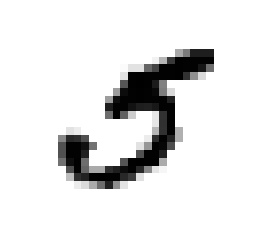

5.0

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()
y[36000]

In [4]:
# Split into training set and test set (with labels)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#Shuffle training set
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a binary classifier

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## Stochastic gradient descent classifier

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [7]:
sgd_clf.predict([some_digit]) # accurately predicts that some_digit is a 5.

array([False], dtype=bool)

# Implementing cross-validation from scratch

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


#     clone_clf = clone(sgd_clf)

0.9666
0.95135
0.95715


## K-fold cross-validation

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9666 ,  0.95135,  0.95715])

## classify "not-5" to show why accuracy is not a preferred performance metric

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [11]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
never_5_pred = never_5_clf.predict(X_train)

# Confusion matrix

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
# get confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53276,  1303],
       [ 1195,  4226]])

## Precision and Recall

In [14]:
from sklearn.metrics import precision_score, recall_score

print("precision:", precision_score(y_train_5, y_train_pred), "Recall:", recall_score(y_train_5, y_train_pred))

precision: 0.764333514198 Recall: 0.779560966611


In [15]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.77187214611872146

## Move decision boundary

In [16]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-144478.50394031])

In [17]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [18]:
threshold = 37000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [19]:
# Use cross_val_predict, but now get the decision scores instead of prediction
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

# Now compute the precision oand recall for all possible
# thresholds using precision_recall_curve()
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, 
                                                         y_scores)

# Now plot the precision and recall as a function of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(20, 10))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(20, 10))
    plt.plot(recalls[:-1], precisions[:-1], "b--", label="Precision")
    plt.xlabel("Recall")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

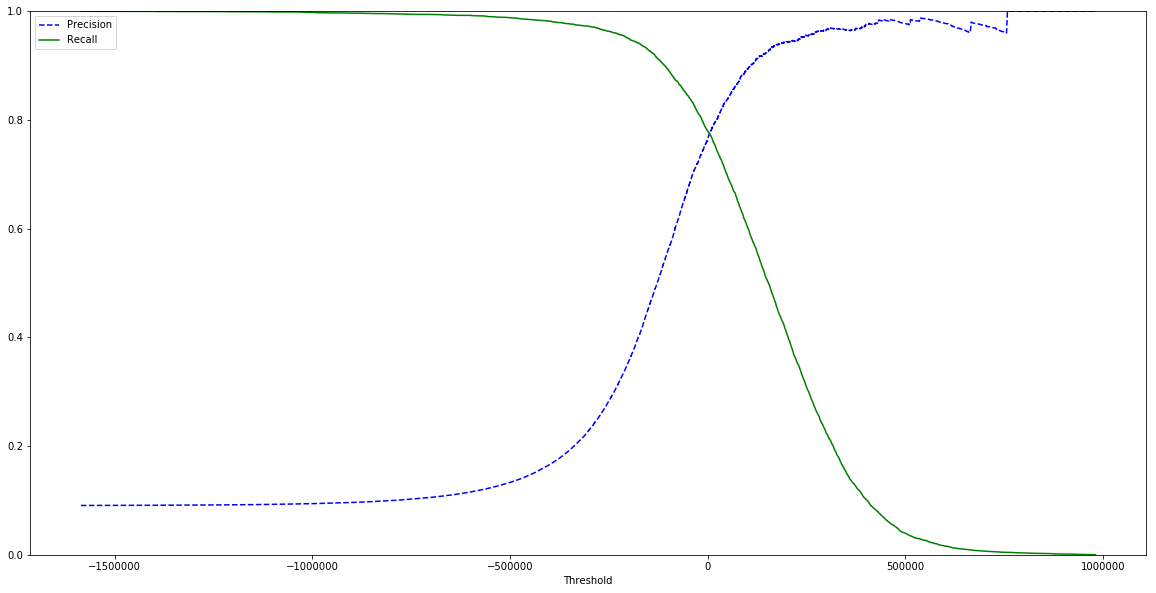

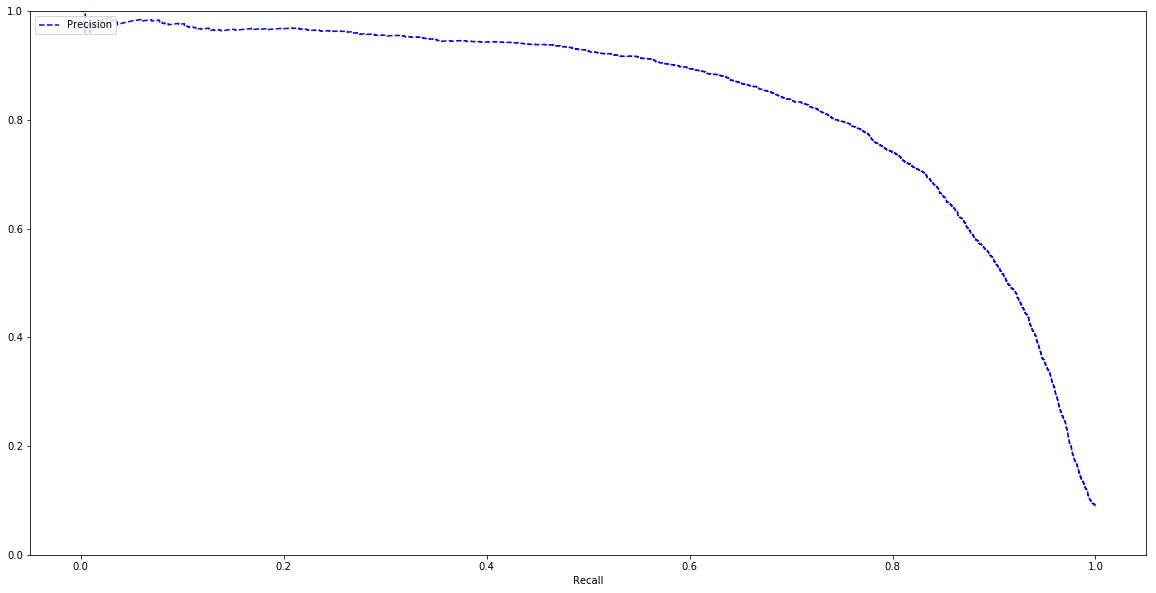

In [20]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
plt.figure()
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [21]:
# 90% precision
y_train_pred_90 = (y_scores > 70000)

print("Precision:", precision_score(y_train_5, y_train_pred_90))
print("Recall:", recall_score(y_train_5, y_train_pred_90))

Precision: 0.861237162646
Recall: 0.665190924184


# Receiver operating characteristic (ROC) curve

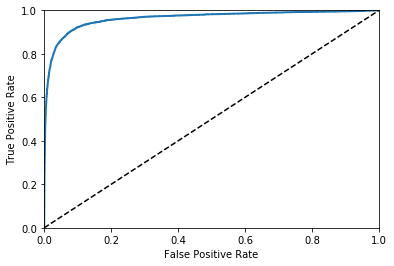

In [22]:
# Plot true-positive rate (aka recall, aka sensitivity) against false-positive rate (1-true negative rate). 
# TNR = specifity. ROC curve plots sensitivity vs (1 - specificity)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

In [23]:
# Measure area under curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores) # Results in a high score due to rareness of positive class

0.96301497631284139

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

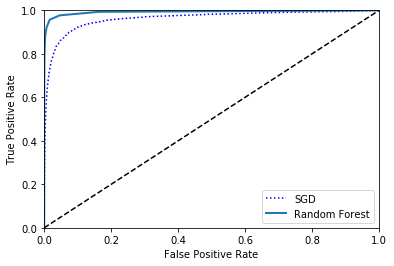

In [25]:
# Need a score, not a probability. 
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

# RF is better than SGD!

In [26]:
# Check the roc_auc_score
print("ROC_AUC_SCORE:", roc_auc_score(y_train_5, y_scores_forest))
print("Precision:", precision_score(y_train_5, [score > .5 for score in y_scores_forest]))
print("Recall:", recall_score(y_train_5, [score > .5 for score in y_scores_forest]))

ROC_AUC_SCORE: 0.992850320161
Precision: 0.983336987503
Recall: 0.827338129496


# Multi-class Classification

In [27]:
# Sklearn automatically detects trying to use a binary classifier for a multiclass classification task and uses OvA
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 0.])

In [28]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -38134.34683968, -466181.16025381, -503720.82568415,
        -328924.3143466 , -414642.95141182, -144478.50394031,
        -715176.60663889, -269306.42807813, -643379.93018684,
        -660758.00959727]])

In [29]:
np.argmax(some_digit_scores)

0

In [30]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [31]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

0.0

In [32]:
# Select OneVsOne classifier or OneVsAll Classifier manually
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [33]:
len(ovo_clf.estimators_)

45

In [34]:
# Now train a random forest multiclass classifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [35]:
# Random forest supports multiclass (stochastic classifier), so one v one and one v all not necessary
# check the predict proba
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0. ,  0.1,  0. ,  0.9,  0. ,  0. ,  0. ,  0. ]])

In [36]:
# Now run cross-validation to evaluate these scores
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.85927814,  0.8679434 ,  0.86988048])

In [37]:
# We can do better than 84%. Try scaling the input to increase accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90916817,  0.90954548,  0.90898635])

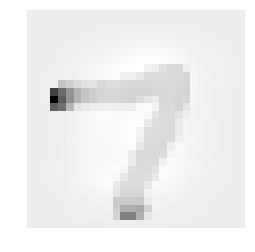

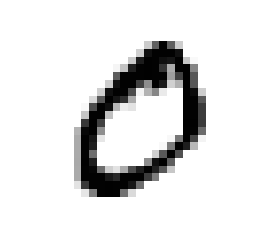

5.0

In [38]:
some_digit = X_train_scaled[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()
plt.figure()
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()
y[36000]

# Error Analysis

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5735,    2,   23,   11,   11,   45,   45,    9,   38,    4],
       [   1, 6459,   45,   27,    6,   37,    7,    9,  138,   13],
       [  55,   41, 5323,   94,   83,   20,   93,   55,  179,   15],
       [  46,   38,  143, 5316,    3,  239,   35,   54,  150,  107],
       [  22,   27,   42,    8, 5362,   12,   44,   26,   71,  228],
       [  70,   47,   34,  175,   74, 4614,  102,   28,  173,  104],
       [  33,   22,   42,    2,   45,   92, 5626,    6,   49,    1],
       [  25,   22,   70,   26,   65,   10,    4, 5792,   16,  235],
       [  47,  154,   72,  147,   14,  158,   57,   20, 5032,  150],
       [  37,   29,   34,   85,  166,   38,    2,  192,   71, 5295]])

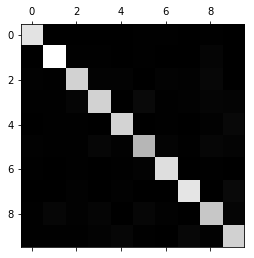

In [40]:
plt.figure(figsize=(20,20))
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [41]:
# Divide each value in the confusion matrix by the number of images in the corresponding class
# To compare error rates instead of absolute number of errors, which would make abundant classes look
# unfairly bad
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

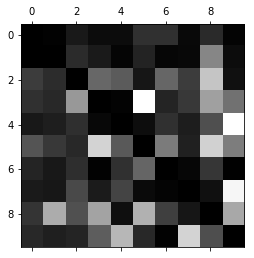

In [42]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# Multilabel Classification

In [43]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False, False]], dtype=bool)

In [44]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

KeyboardInterrupt: 

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_text_mod[some_index]])
plot_digit(clean_digit)